<a href="https://colab.research.google.com/github/esha1701/BloodGlucose-LSTM/blob/main/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [182]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import math

In [183]:
import warnings
warnings.filterwarnings('ignore')

## Data Extraction, Preprocessing & Exploration

### Loading CGM Data 

In [184]:
# getting file containing only blood glucose values
bgdf = pd.read_csv("/content/bg-Table 1.csv")
bgdf

,type,sourceName,value,unit,startDate,endDate,creationDate,com.loopkit.InsulinKit.MetadataKeyProgrammedTempBasalRate,com.loopkit.InsulinKit.MetadataKeyScheduledBasalRate,com.loudnate.CarbKit.HKMetadataKey.AbsorptionTimeMinutes,FitzpatrickSkinType,HKMetadataKeySyncVersion,CardioFitnessMedicationsUse,sourceVersion,HasLoopKitOrigin,Transmitter Time,Status,BloodType,BiologicalSex,Trend Arrow,HKInsulinDeliveryReason,HKMetadataKeyDevicePlacementSide,com.loudnate.GlucoseKit.HKMetadataKey.GlucoseIsDisplayOnly,HKFoodType,device,DateOfBirth,HKTimeZone,HKDeviceName,Trend Rate,HKWasUserEntered,HKMetadataKeySyncIdentifier
0,BloodGlucose,Loop,126,mg/dL,11/1/21 0:05,11/1/21 0:05,11/1/21 0:05,NaN,NaN,NaN,NaN,1.0,NaN,57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,"<<HKDevice: 0x28014c000>, name:CGMBLEKit, manu...",NaN,NaN,NaN,NaN,NaN,8MB5QB 3729973
1,BloodGlucose,Loop,126,mg/dL,11/1/21 0:00,11/1/21 0:00,11/1/21 0:00,NaN,NaN,NaN,NaN,1.0,NaN,57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,"<<HKDevice: 0x28014c000>, name:CGMBLEKit, manu...",NaN,NaN,NaN,NaN,NaN,8MB5QB 3729673
2,BloodGlucose,Loop,121,mg/dL,10/31/21 23:55,10/31/21 23:55,10/31/21 23:55,NaN,NaN,NaN,NaN,1.0,NaN,57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,"<<HKDevice: 0x28014c000>, name:CGMBLEKit, manu...",NaN,NaN,NaN,NaN,NaN,8MB5QB 3729373
3,BloodGlucose,Loop,122,mg/dL,10/31/21 23:50,10/31/21 23:50,10/31/21 23:50,NaN,NaN,NaN,NaN,1.0,NaN,57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,"<<HKDevice: 0x28014c000>, name:CGMBLEKit, manu...",NaN,NaN,NaN,NaN,NaN,8MB5QB 3729073
4,BloodGlucose,Loop,123,mg/dL,10/31/21 23:45,10/31/21 23:45,10/31/21 23:45,NaN,NaN,NaN,NaN,1.0,NaN,57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,"<<HKDevice: 0x28014c000>, name:CGMBLEKit, manu...",NaN,NaN,NaN,NaN,NaN,8MB5QB 3728773
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65529,BloodGlucose,Dexcom G6,132,mg/dL,3/10/21 16:37,3/10/21 16:37,3/10/21 19:42,NaN,NaN,NaN,NaN,NaN,NaN,16629,NaN,2021-03-10 20:37:01 +0000,IN_RANGE,NaN,NaN,Flat,NaN,NaN,NaN,NaN,NaN,NaN,America/New_York,1.038627e+13,0.2,NaN,NaN
65530,BloodGlucose,Dexcom G6,129,mg/dL,3/10/21 16:32,3/10/21 16:32,3/10/21 19:37,NaN,NaN,NaN,NaN,NaN,NaN,16629,NaN,2021-03-10 20:32:01 +0000,IN_RANGE,NaN,NaN,Flat,NaN,NaN,NaN,NaN,NaN,NaN,America/New_York,1.038627e+13,-0.2,NaN,NaN
65531,BloodGlucose,Dexcom G6,128,mg/dL,3/10/21 16:27,3/10/21 16:27,3/10/21 19:32,NaN,NaN,NaN,NaN,NaN,NaN,16629,NaN,2021-03-10 20:27:01 +0000,IN_RANGE,NaN,NaN,Flat,NaN,NaN,NaN,NaN,NaN,NaN,America/New_York,1.038627e+13,0.0,NaN,NaN
65532,BloodGlucose,Dexcom G6,129,mg/dL,3/10/21 16:22,3/10/21 16:22,3/10/21 19:27,NaN,NaN,NaN,NaN,NaN,NaN,16629,NaN,2021-03-10 20:22:01 +0000,IN_RANGE,NaN,NaN,Flat,NaN,NaN,NaN,NaN,NaN,NaN,America/New_York,1.038627e+13,0.0,NaN,NaN


We are only interested in the timestamps and value of blood glucose values. The rest of the columns are all interal [Loop ](https://loopkit.github.io/loopdocs/)states which can be dropped.

In [185]:
# We only need time & bg values, rest of the column are internal loop states 
bgdf = bgdf[["startDate","value"]]
bgdf['startDate'] = pd.to_datetime(bgdf['startDate']) 
bgdf

,startDate,value
0,2021-11-01 00:05:00,126
1,2021-11-01 00:00:00,126
2,2021-10-31 23:55:00,121
3,2021-10-31 23:50:00,122
4,2021-10-31 23:45:00,123
...,...,...
65529,2021-03-10 16:37:00,132
65530,2021-03-10 16:32:00,129
65531,2021-03-10 16:27:00,128
65532,2021-03-10 16:22:00,129


### Blood Glucose Stats

In [186]:
maxBG = bgdf['value'].max()
minBG = bgdf['value'].min()
meanBG = bgdf['value'].mean()
stdBG = bgdf['value'].std()

print('Maximum blood glucose:', maxBG, 'mg/dl')
print('Minimum blood glucose:', minBG,'mg/dl')
print('Mean blood glucose:', meanBG,'mg/dl')
print('Standard deviation:', stdBG,'mg/dl')

Maximum blood glucose: 262 mg/dl
Minimum blood glucose: 39 mg/dl
Mean blood glucose: 116.70767845698415 mg/dl
Standard deviation: 25.835676287466875 mg/dl


Hyperglycemic threshold is 180mg/dl and hypoglycemic threshold 70mg/dl.

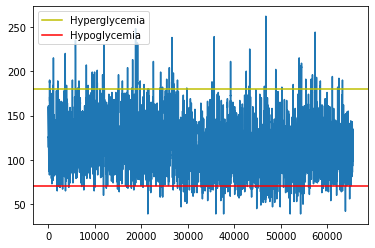

In [187]:

plt.plot(bgdf['value'])
plt.axhline(y = 180, color = 'y', linestyle = '-',label = 'Hyperglycemia')
plt.axhline(y = 70, color = 'r', linestyle = '-', label = 'Hypoglycemia')
plt.legend()



### Loading Carbohydrate Data

In [188]:
carbsdf = pd.read_csv("carbs-Table 1.csv")
carbsdf


,type,sourceName,value,unit,startDate,endDate,creationDate,com.loopkit.InsulinKit.MetadataKeyProgrammedTempBasalRate,com.loopkit.InsulinKit.MetadataKeyScheduledBasalRate,com.loudnate.CarbKit.HKMetadataKey.AbsorptionTimeMinutes,FitzpatrickSkinType,HKMetadataKeySyncVersion,CardioFitnessMedicationsUse,sourceVersion,HasLoopKitOrigin,Transmitter Time,Status,BloodType,BiologicalSex,Trend Arrow,HKInsulinDeliveryReason,HKMetadataKeyDevicePlacementSide,com.loudnate.GlucoseKit.HKMetadataKey.GlucoseIsDisplayOnly,HKFoodType,device,DateOfBirth,HKTimeZone,HKDeviceName,Trend Rate,HKWasUserEntered,HKMetadataKeySyncIdentifier
0,DietaryCarbohydrates,Loop,113.0,g,10/31/21 22:10,10/31/21 22:10,10/31/21 22:10,NaN,NaN,14400,NaN,1,NaN,57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,salad cb,NaN,NaN,NaN,NaN,NaN,NaN,FFA616A1-0FF5-42CE-8169-CFF32DDC5234
1,DietaryCarbohydrates,Loop,41.0,g,10/31/21 19:00,10/31/21 19:00,10/31/21 19:00,NaN,NaN,10800,NaN,1,NaN,57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,grapes c&c pbj,NaN,NaN,NaN,NaN,NaN,NaN,F00BAD19-691F-40B0-89D0-6E494EA03E28
2,DietaryCarbohydrates,Loop,41.0,g,10/31/21 10:02,10/31/21 10:02,10/31/21 10:02,NaN,NaN,7200,NaN,1,NaN,57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,grapes c&c,NaN,NaN,NaN,NaN,NaN,NaN,A3AD5E02-9EDA-4B31-A75E-F79D28C761A8
3,DietaryCarbohydrates,Loop,129.0,g,10/30/21 22:43,10/30/21 22:43,10/30/21 22:44,NaN,NaN,14400,NaN,1,NaN,57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,eggs rolls pbj,NaN,NaN,NaN,NaN,NaN,NaN,D449FC63-5104-4D4E-998D-44DCE4C89294
4,DietaryCarbohydrates,Loop,41.0,g,10/30/21 18:53,10/30/21 18:53,10/30/21 18:54,NaN,NaN,10800,NaN,1,NaN,57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,grapes c&c pbj,NaN,NaN,NaN,NaN,NaN,NaN,646F79C0-A8B5-4132-8F8B-8BE5C3C892F6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1275,DietaryCarbohydrates,Loop,98.0,g,11/27/20 23:20,11/27/20 23:20,11/27/20 23:22,NaN,NaN,10800,NaN,1,NaN,57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"salad cornbread 92,111",NaN,NaN,NaN,NaN,NaN,NaN,9D494DA8-6B7E-4544-BC69-57F18DC9392C
1276,DietaryCarbohydrates,Loop,16.0,g,11/27/20 21:05,11/27/20 21:05,11/27/20 21:07,NaN,NaN,10800,NaN,1,NaN,57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1/2 juice c&c grapes,NaN,NaN,NaN,NaN,NaN,NaN,B41CEC83-04D5-4D83-AA9C-E3FBAA7C84CB
1277,DietaryCarbohydrates,Loop,16.0,g,11/27/20 13:18,11/27/20 13:18,11/27/20 13:27,NaN,NaN,10800,NaN,2,NaN,57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"c&c, grapes",NaN,NaN,NaN,NaN,NaN,NaN,9834704F-BA5C-4DDF-BCB5-29CE2134A291
1278,DietaryCarbohydrates,Loop,16.0,g,11/27/20 10:36,11/27/20 10:36,11/27/20 13:27,NaN,NaN,7200,NaN,2,NaN,57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,juice bottle,NaN,NaN,NaN,NaN,NaN,NaN,BDA0B662-6BD4-4398-A21E-27A22558A9DA


Again, dropping internal Loop states and keeping only the timestamps and carbohydrate intake values.

In [189]:
carbsdf = carbsdf[["startDate","value"]]
carbsdf ['startDate'] = pd.to_datetime(carbsdf ['startDate'])
carbsdf

,startDate,value
0,2021-10-31 22:10:00,113.0
1,2021-10-31 19:00:00,41.0
2,2021-10-31 10:02:00,41.0
3,2021-10-30 22:43:00,129.0
4,2021-10-30 18:53:00,41.0
...,...,...
1275,2020-11-27 23:20:00,98.0
1276,2020-11-27 21:05:00,16.0
1277,2020-11-27 13:18:00,16.0
1278,2020-11-27 10:36:00,16.0


### Carbohydrate Intake Stats

In [190]:
Cdays = carbsdf['startDate'][0] - carbsdf['startDate'][len(carbsdf)-1]
avgmeals = len(carbsdf)/Cdays.days
"Average number of meals per day:", avgmeals

('Average number of meals per day:', 3.78698224852071)

In [191]:
max_carbs= carbsdf['value'].max()
'Maximum Carbs:', max_carbs, 'g'

('Maximum Carbs:', 140.0, 'g')

## Loading Insulin Data

In [192]:
insulindf = pd.read_csv("insulin-Table 1.csv")
insulindf

,type,sourceName,value,unit,startDate,endDate,creationDate,com.loopkit.InsulinKit.MetadataKeyProgrammedTempBasalRate,com.loopkit.InsulinKit.MetadataKeyScheduledBasalRate,com.loudnate.CarbKit.HKMetadataKey.AbsorptionTimeMinutes,FitzpatrickSkinType,HKMetadataKeySyncVersion,CardioFitnessMedicationsUse,sourceVersion,HasLoopKitOrigin,Transmitter Time,Status,BloodType,BiologicalSex,Trend Arrow,HKInsulinDeliveryReason,HKMetadataKeyDevicePlacementSide,com.loudnate.GlucoseKit.HKMetadataKey.GlucoseIsDisplayOnly,HKFoodType,device,DateOfBirth,HKTimeZone,HKDeviceName,Trend Rate,HKWasUserEntered,HKMetadataKeySyncIdentifier
0,InsulinDelivery,Loop,0.05,IU,10/31/21 23:55,10/31/21 23:55,11/1/21 0:00,NaN,NaN,NaN,NaN,1,NaN,57,1,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,"<<HKDevice: 0x280148050>, name:Omnipod, manufa...",NaN,NaN,NaN,NaN,NaN,626f6c757320302e303520323032312d31312d30315430...
1,InsulinDelivery,Loop,0.10,IU,10/31/21 23:40,10/31/21 23:40,10/31/21 23:50,NaN,NaN,NaN,NaN,1,NaN,57,1,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,"<<HKDevice: 0x280148050>, name:Omnipod, manufa...",NaN,NaN,NaN,NaN,NaN,626f6c757320302e3120323032312d31312d3031543033...
2,InsulinDelivery,Loop,0.00,IU,10/31/21 23:05,10/31/21 23:25,10/31/21 23:25,0 IU/hr,0.4 IU/hr,NaN,NaN,1,NaN,57,1,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,"<<HKDevice: 0x280148050>, name:Omnipod, manufa...",NaN,NaN,NaN,NaN,NaN,74656d70426173616c20302e3020323032312d31312d30...
3,InsulinDelivery,Loop,0.00,IU,10/31/21 23:05,10/31/21 23:05,10/31/21 23:25,NaN,NaN,NaN,NaN,1,NaN,57,1,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,"<<HKDevice: 0x280148050>, name:Omnipod, manufa...",NaN,NaN,NaN,NaN,NaN,BasalRateSchedule 2021-11-01T03:05:36Z 2021-11...
4,InsulinDelivery,Loop,0.00,IU,10/31/21 22:45,10/31/21 23:05,10/31/21 23:05,0 IU/hr,0.4 IU/hr,NaN,NaN,1,NaN,57,1,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,"<<HKDevice: 0x280148050>, name:Omnipod, manufa...",NaN,NaN,NaN,NaN,NaN,74656d70426173616c20302e3020323032312d31312d30...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47969,InsulinDelivery,Loop,0.80,IU,11/27/20 5:00,11/27/20 6:00,11/27/20 9:52,NaN,NaN,NaN,NaN,1,NaN,57,1,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,"<<HKDevice: 0x280154320>, name:Omnipod, manufa...",NaN,NaN,NaN,NaN,NaN,BasalRateSchedule 2020-11-27T09:00:00Z 2020-11...
47970,InsulinDelivery,Loop,1.70,IU,11/27/20 3:00,11/27/20 5:00,11/27/20 9:52,NaN,NaN,NaN,NaN,1,NaN,57,1,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,"<<HKDevice: 0x280154320>, name:Omnipod, manufa...",NaN,NaN,NaN,NaN,NaN,BasalRateSchedule 2020-11-27T07:00:00Z 2020-11...
47971,InsulinDelivery,Loop,0.80,IU,11/27/20 2:00,11/27/20 3:00,11/27/20 9:52,NaN,NaN,NaN,NaN,1,NaN,57,1,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,"<<HKDevice: 0x280154320>, name:Omnipod, manufa...",NaN,NaN,NaN,NaN,NaN,BasalRateSchedule 2020-11-27T06:00:00Z 2020-11...
47972,InsulinDelivery,Loop,0.75,IU,11/27/20 1:00,11/27/20 2:00,11/27/20 9:52,NaN,NaN,NaN,NaN,1,NaN,57,1,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,"<<HKDevice: 0x280154320>, name:Omnipod, manufa...",NaN,NaN,NaN,NaN,NaN,BasalRateSchedule 2020-11-27T05:00:00Z 2020-11...


In [193]:
bolusdf = insulindf[['startDate','endDate','value']]
bolusdf['startDate'] =  pd.to_datetime(insulindf['startDate'])
bolusdf['endDate'] =  pd.to_datetime(insulindf['endDate'])
time_duration = bolusdf['endDate'] - bolusdf['startDate']
time_duration = time_duration.dt.seconds
bolusdf['time_duration(sec)'] = time_duration 
bolusdf

,startDate,endDate,value,time_duration(sec)
0,2021-10-31 23:55:00,2021-10-31 23:55:00,0.05,0
1,2021-10-31 23:40:00,2021-10-31 23:40:00,0.10,0
2,2021-10-31 23:05:00,2021-10-31 23:25:00,0.00,1200
3,2021-10-31 23:05:00,2021-10-31 23:05:00,0.00,0
4,2021-10-31 22:45:00,2021-10-31 23:05:00,0.00,1200
...,...,...,...,...
47969,2020-11-27 05:00:00,2020-11-27 06:00:00,0.80,3600
47970,2020-11-27 03:00:00,2020-11-27 05:00:00,1.70,7200
47971,2020-11-27 02:00:00,2020-11-27 03:00:00,0.80,3600
47972,2020-11-27 01:00:00,2020-11-27 02:00:00,0.75,3600


We add an extra column ``` time_duration ``` which calculates how long an insulin dose was given for. We only want to consider boluses in our model so we drop all rows which have an insulin dose less than 0.6 IU or took over 10 minutes to deliver.





In [194]:
# Dropping basal values
basal_val1 = bolusdf[bolusdf['value']<0.6 ].index
bolusdf.drop(basal_val1 , inplace=True)
basal_val2 = bolusdf[bolusdf['time_duration(sec)']>600].index
bolusdf.drop(basal_val2 , inplace=True)
bolusdf = bolusdf.drop(['time_duration(sec)','endDate'],axis=1)

In [195]:
bolusdf

,startDate,value
7,2021-10-31 22:10:00,3.75
18,2021-10-31 19:00:00,1.55
67,2021-10-31 10:02:00,1.60
129,2021-10-30 22:44:00,4.25
149,2021-10-30 18:54:00,1.65
...,...,...
47924,2020-11-28 21:13:00,7.30
47938,2020-11-28 16:44:00,2.40
47941,2020-11-28 14:53:00,1.10
47948,2020-11-28 05:13:00,1.65


### Bolus Stats

In [196]:
Bdays = bolusdf['startDate'][7] - bolusdf['startDate'][47954]
avgbolus = len(bolusdf)/Bdays.days
"Average number of boluses per day:", avgbolus


('Average number of boluses per day:', 2.4688427299703264)

In [197]:
"Average bolus units:", bolusdf['value'].mean()

('Average bolus units:', 3.2859975961538477)

In [198]:
max_bolus= bolusdf['value'].max()
'Maximum Bolus:', max_bolus, 'units'

('Maximum Bolus:', 10.8, 'units')

Currently we have three separate tables for blood glucose, carbohydrates and insulin. We need to get all of them in a single table, with values of bg, carbs and bolus for every single timestamp (i.e. for ever 5 minute interval). Since CGM sensors have to be changed every 10 days and have a 2 hour warmup period, there are gaps in the time intervals. Thus, we create a new dataframe with 5 minute time intervals. 

In [2]:
import pandas as pd
timestamps = pd.date_range('2021-03-11','2021-10-31', freq='5min')
timedf = pd.DataFrame({'startDate':timestamps})
timedf

,startDate
0,2021-03-11 00:00:00
1,2021-03-11 00:05:00
2,2021-03-11 00:10:00
3,2021-03-11 00:15:00
4,2021-03-11 00:20:00
...,...
67388,2021-10-30 23:40:00
67389,2021-10-30 23:45:00
67390,2021-10-30 23:50:00
67391,2021-10-30 23:55:00


Merging the data in each of the 3 tables to the closest 5 minute timestamp.

In [199]:
#pandas.merge_asof only works on sorted dataframes
bgdf = bgdf[::-1]
bolusdf = bolusdf[::-1]
carbsdf = carbsdf[::-1]

In [201]:
datadf = pd.merge_asof(timedf, bgdf, on="startDate", tolerance=pd.Timedelta('5min'))
datadf = pd.merge_asof(datadf, carbsdf, on="startDate", tolerance=pd.Timedelta('5min'))
datadf = pd.merge_asof(datadf, bolusdf, on="startDate", tolerance=pd.Timedelta('5min'))
datadf = datadf.rename(columns={"value_x": "BG", "value_y": "Carbs","value": "Bolus"})
datadf

,startDate,BG,Carbs,Bolus
0,2021-03-11 00:00:00,100.0,NaN,NaN
1,2021-03-11 00:05:00,99.0,NaN,NaN
2,2021-03-11 00:10:00,100.0,NaN,NaN
3,2021-03-11 00:15:00,102.0,NaN,NaN
4,2021-03-11 00:20:00,104.0,NaN,NaN
...,...,...,...,...
67388,2021-10-30 23:40:00,156.0,NaN,NaN
67389,2021-10-30 23:45:00,154.0,NaN,NaN
67390,2021-10-30 23:50:00,156.0,NaN,NaN
67391,2021-10-30 23:55:00,158.0,NaN,NaN


We get the missing blood glucose values through linear interpolation and set carb & bolus values to 0 for the timestamps with no entries.

In [202]:
datadf['BG']= datadf['BG'].interpolate(method='linear')
datadf['Carbs'] = datadf['Carbs'].fillna(0)
datadf['Bolus'] = datadf['Bolus'].fillna(0)
datadf[-30:-1]

,startDate,BG,Carbs,Bolus
67363,2021-10-30 21:35:00,162.0,0.0,0.00
67364,2021-10-30 21:40:00,163.0,0.0,0.00
67365,2021-10-30 21:45:00,163.0,0.0,0.00
67366,2021-10-30 21:50:00,169.0,0.0,0.00
67367,2021-10-30 21:55:00,170.0,0.0,0.00
67368,2021-10-30 22:00:00,171.0,0.0,0.00
67369,2021-10-30 22:05:00,168.0,0.0,0.00
67370,2021-10-30 22:10:00,166.0,0.0,0.00
67371,2021-10-30 22:15:00,164.0,0.0,0.00
67372,2021-10-30 22:20:00,165.0,0.0,0.00


In [203]:
datadf = datadf.drop(['startDate'],axis = 1)
data_as_np = datadf.to_numpy()
data_as_np

array([[100.,   0.,   0.],
       [ 99.,   0.,   0.],
       [100.,   0.,   0.],
       ...,
       [156.,   0.,   0.],
       [158.,   0.,   0.],
       [158.,   0.,   0.]])

Plotting 288 readings to get the graph for blood glucose, bolus and carboydrate values for 24 hours.


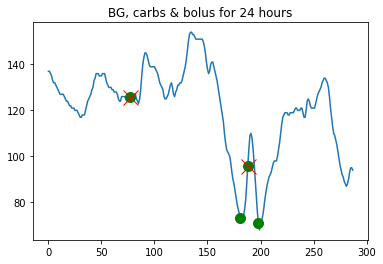

In [204]:
#plotting a random day
plt.plot(data_as_np[9000:9288,0])
carb_list = []
for i in range(9000,9288):
  if data_as_np[i][1]!=0:
    plt.plot(i-9000,data_as_np[i][0],'o',color='green', markersize=10)
  if data_as_np[i][2]!=0:
    plt.plot(i-9000,data_as_np[i][0],'x',color='red', markersize=15)
plt.title('BG, carbs & bolus for 24 hours')
plt.show()



## Model Training

We will be using 2 hour history of blood glucose values, carbs and bolus to forecast 60 minute blood glucose values in the future.

In [205]:
def np_to_X_y(data, window_size, future_steps):
  """
  Function to input and output data arrays for LSTM model
  params:
    data (array)       : numpy array containing bg value, carbs and insulin  
    window_size (int)  : number of previous timesteps/memory needed for prediction
    future_steps (int) : number of timesteps for prediction   

  returns:
    X (np.array)      : input array having previous 120 minute bg value, carbs, insulin
    y (np.array)      : output array having next 60 minute bg values
  """
  X = []
  y = []
  for i in range(len(data)-window_size-future_steps-1):
    row = [a for a in data[i:i+window_size]]
    X.append(row)
    label = [data[j][0] for j in range(i+window_size,i+window_size+future_steps)]
    y.append(label)
  return np.asarray(X).astype(np.float32),  np.asarray(y).astype(np.float32)

In [206]:
# Creating input & labels for LSTM 
history = 24 #120/5
future = 12 #60/5
X, y = np_to_X_y(data_as_np, history, future)
X.shape, y.shape

((67356, 24, 3), (67356, 12))

Splitting data into train, validation and testset.

In [207]:
X_train, y_train = X[:35000], y[:35000]
X_val, y_val = X[35000:50000], y[35000:50000]
X_test,y_test = X[50000:], y[50000:]
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape)

(35000, 24, 3) (35000, 12) (15000, 24, 3) (15000, 12) (17356, 24, 3) (17356, 12)


In [208]:
X_train, y_train

(array([[[100.,   0.,   0.],
         [ 99.,   0.,   0.],
         [100.,   0.,   0.],
         ...,
         [140.,   0.,   0.],
         [143.,   0.,   0.],
         [143.,   0.,   0.]],
 
        [[ 99.,   0.,   0.],
         [100.,   0.,   0.],
         [102.,   0.,   0.],
         ...,
         [143.,   0.,   0.],
         [143.,   0.,   0.],
         [140.,   0.,   0.]],
 
        [[100.,   0.,   0.],
         [102.,   0.,   0.],
         [104.,   0.,   0.],
         ...,
         [143.,   0.,   0.],
         [140.,   0.,   0.],
         [137.,   0.,   0.]],
 
        ...,
 
        [[156.,   0.,   0.],
         [155.,   0.,   0.],
         [154.,   0.,   0.],
         ...,
         [126.,   0.,   0.],
         [125.,   0.,   0.],
         [125.,   0.,   0.]],
 
        [[155.,   0.,   0.],
         [154.,   0.,   0.],
         [152.,   0.,   0.],
         ...,
         [125.,   0.,   0.],
         [125.,   0.,   0.],
         [126.,   0.,   0.]],
 
        [[154.,   0.,   0.],
 

On running multiple experiments and hyperparameter tuning, we find that the best structure is a LSTM layer of 70 units with a relu activation function. The MSE objective is minimized using Adam and a learning rate of 0.0001. The number of train epochs was 20 iterations.

In [209]:
model = Sequential()
model.add(LSTM(70,activation='relu',input_shape=(X_train.shape[1],X_train.shape[2])))
model.add(Dense(future))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 70)                20720     
                                                                 
 dense_1 (Dense)             (None, 12)                852       
                                                                 
Total params: 21,572
Trainable params: 21,572
Non-trainable params: 0
_________________________________________________________________


In [210]:
cp1 = ModelCheckpoint('model/', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [211]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, callbacks=[cp1])

Epoch 1/20
1091/1094 [============================>.] - ETA: 0s - loss: 3214.6704 - root_mean_squared_error: 56.6981INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1094/1094 [==============================] - 25s 21ms/step - loss: 3207.5513 - root_mean_squared_error: 56.6352 - val_loss: 424.5740 - val_root_mean_squared_error: 20.6052
Epoch 2/20
1091/1094 [============================>.] - ETA: 0s - loss: 313.3837 - root_mean_squared_error: 17.7026INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1094/1094 [==============================] - 24s 21ms/step - loss: 313.2578 - root_mean_squared_error: 17.6991 - val_loss: 310.1481 - val_root_mean_squared_error: 17.6110
Epoch 3/20
1094/1094 [==============================] - ETA: 0s - loss: 229.0933 - root_mean_squared_error: 15.1358INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1094/1094 [==============================] - 22s 20ms/step - loss: 229.0933 - root_mean_squared_error: 15.1358 - val_loss: 250.6891 - val_root_mean_squared_error: 15.8332
Epoch 4/20
1091/1094 [============================>.] - ETA: 0s - loss: 197.1951 - root_mean_squared_error: 14.0426INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1094/1094 [==============================] - 22s 20ms/step - loss: 197.1444 - root_mean_squared_error: 14.0408 - val_loss: 227.7479 - val_root_mean_squared_error: 15.0913
Epoch 5/20
1094/1094 [==============================] - ETA: 0s - loss: 202.6136 - root_mean_squared_error: 14.2342INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1094/1094 [==============================] - 23s 21ms/step - loss: 202.6136 - root_mean_squared_error: 14.2342 - val_loss: 220.8688 - val_root_mean_squared_error: 14.8617
Epoch 6/20
1094/1094 [==============================] - 21s 19ms/step - loss: 190.2655 - root_mean_squared_error: 13.7937 - val_loss: 223.1961 - val_root_mean_squared_error: 14.9397
Epoch 7/20
1093/1094 [============================>.] - ETA: 0s - loss: 170.8236 - root_mean_squared_error: 13.0700INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1094/1094 [==============================] - 27s 25ms/step - loss: 170.7793 - root_mean_squared_error: 13.0683 - val_loss: 199.0467 - val_root_mean_squared_error: 14.1084
Epoch 8/20
1094/1094 [==============================] - ETA: 0s - loss: 163.4614 - root_mean_squared_error: 12.7852INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1094/1094 [==============================] - 23s 21ms/step - loss: 163.4614 - root_mean_squared_error: 12.7852 - val_loss: 187.9634 - val_root_mean_squared_error: 13.7100
Epoch 9/20
1092/1094 [============================>.] - ETA: 0s - loss: 158.4968 - root_mean_squared_error: 12.5895INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1094/1094 [==============================] - 23s 21ms/step - loss: 158.4109 - root_mean_squared_error: 12.5861 - val_loss: 185.1580 - val_root_mean_squared_error: 13.6073
Epoch 10/20
1094/1094 [==============================] - 21s 19ms/step - loss: 158.2276 - root_mean_squared_error: 12.5788 - val_loss: 193.9070 - val_root_mean_squared_error: 13.9250
Epoch 11/20
1093/1094 [============================>.] - ETA: 0s - loss: 154.4189 - root_mean_squared_error: 12.4265INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1094/1094 [==============================] - 23s 21ms/step - loss: 154.4385 - root_mean_squared_error: 12.4273 - val_loss: 181.8184 - val_root_mean_squared_error: 13.4840
Epoch 12/20
1092/1094 [============================>.] - ETA: 0s - loss: 152.0704 - root_mean_squared_error: 12.3317INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1094/1094 [==============================] - 23s 21ms/step - loss: 152.1633 - root_mean_squared_error: 12.3354 - val_loss: 175.4824 - val_root_mean_squared_error: 13.2470
Epoch 13/20
1094/1094 [==============================] - 20s 19ms/step - loss: 166.0548 - root_mean_squared_error: 12.8862 - val_loss: 184.9268 - val_root_mean_squared_error: 13.5988
Epoch 14/20
1094/1094 [==============================] - 21s 19ms/step - loss: 166.1724 - root_mean_squared_error: 12.8908 - val_loss: 182.9161 - val_root_mean_squared_error: 13.5246
Epoch 15/20
1094/1094 [==============================] - 21s 19ms/step - loss: 157.2852 - root_mean_squared_error: 12.5413 - val_loss: 180.6705 - val_root_mean_squared_error: 13.4414
Epoch 16/20
1094/1094 [==============================] - 21s 19ms/step - loss: 148.1547 - root_mean_squared_error: 12.1719 - val_loss: 175.6810 - val_root_mean_squared_error: 13.2545
Epoch 17/20
1093/1094 [============================>.] - ETA: 0s - loss: 146.3279 - root_mean_squ

INFO:tensorflow:Assets written to: model/assets


1094/1094 [==============================] - 23s 21ms/step - loss: 146.3179 - root_mean_squared_error: 12.0962 - val_loss: 172.0038 - val_root_mean_squared_error: 13.1150
Epoch 18/20
1094/1094 [==============================] - 21s 19ms/step - loss: 146.3342 - root_mean_squared_error: 12.0969 - val_loss: 176.4533 - val_root_mean_squared_error: 13.2836
Epoch 19/20
1094/1094 [==============================] - 21s 19ms/step - loss: 148.4796 - root_mean_squared_error: 12.1852 - val_loss: 174.5505 - val_root_mean_squared_error: 13.2118
Epoch 20/20
1092/1094 [============================>.] - ETA: 0s - loss: 142.6714 - root_mean_squared_error: 11.9445INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


1094/1094 [==============================] - 23s 21ms/step - loss: 142.6401 - root_mean_squared_error: 11.9432 - val_loss: 166.5901 - val_root_mean_squared_error: 12.9070


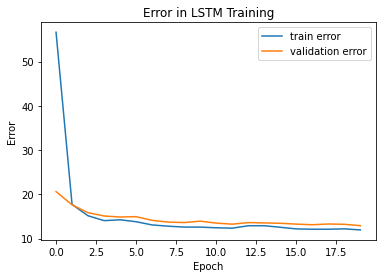

In [234]:
plt.plot(history.history['root_mean_squared_error'], label='train error')
plt.plot(history.history['val_root_mean_squared_error'], label='validation error')
plt.title("Error in LSTM Training")
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.legend()
plt.show()

Root mean squared error can be a catastrophic evaluation metric for blood glucose predictions. It doesn't help if you are a 100% accurate half of the time and completely off the other half. So we need to find better ways to evaluate accuracy of predictions. One way implemented here is by plotting random 60 minute predictions, since that is what the patient at the user end would see it make treatment decisions. 

In [298]:
def plotBG(index, predictions, true):

  """
  Function to compare 60 minute prediction and true blood glucose values.
  Params:
    index (int)          : Index of prediction array i.e. time instance of prediction
    predictions (array)  : LSTM model bg predictions
    true (array)         : True bg values 

  """

  time = [i for i in range(5,65,5)]
  plt.plot(time, predictions[index],'r',label='Prediction')
  plt.plot(time, true[index],label='True')
  plt.ylim(60,200)
  plt.xlabel('Time in minutes')
  plt.ylabel('BG in mg/dl')
  plt.legend()
  pddata= pd.DataFrame(data={'Predictions': predictions[index], 'Actuals':true[index]})
  print(pddata)
  rmse = math.sqrt(mean_squared_error(predictions[index], true[index]))
  print("Root Mean Squared Error: ",rmse)

In [299]:
train_predictions = model.predict(X_train)
train_results = pd.DataFrame(data={'Train Predictions':train_predictions.flatten(), 'True Value':y_train.flatten()})
train_results

,Train Predictions,True Value
0,141.230087,140.0
1,141.358841,137.0
2,141.584641,136.0
3,142.055145,137.0
4,142.278412,139.0
...,...,...
419995,129.521805,134.0
419996,127.855820,136.0
419997,129.378082,138.0
419998,127.431061,139.0


In [300]:
rmse = math.sqrt(mean_squared_error(y_train,train_predictions))
rmse

11.768449299962219

    Predictions  Actuals
0    141.393356    143.0
1    140.888535    142.0
2    142.285339    141.0
3    140.213379    140.0
4    141.613632    139.0
5    140.225113    138.0
6    140.516388    138.0
7    141.044388    139.0
8    138.653259    138.0
9    138.956787    134.0
10   137.247208    132.0
11   136.295609    131.0
Root Mean Squared Error:  3.0052920395395724


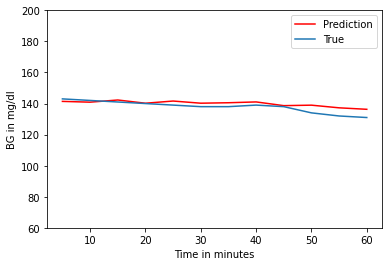

In [301]:
plotBG(10, train_predictions, y_train)

    Predictions  Actuals
0     89.043617     88.0
1     87.795349     84.0
2     87.210060     83.0
3     86.995728     84.0
4     88.577194     86.0
5     87.859543     87.0
6     89.428436     87.0
7     90.042671     85.0
8     89.236198     83.0
9     90.854691     82.0
10    91.258163     82.0
11    92.557045     83.0
Root Mean Squared Error:  5.592001700372396


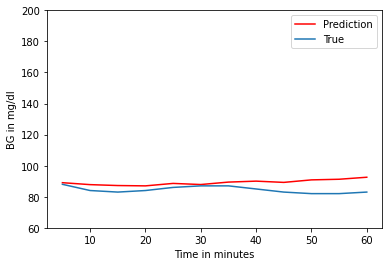

In [302]:
plotBG(89, train_predictions, y_train)


In [303]:
val_predictions = model.predict(X_val)
val_results = pd.DataFrame(data={'Val Predictions':val_predictions.flatten(), 'True Value':y_val.flatten()})
val_results

,Val Predictions,True Value
0,130.720657,130.0
1,131.595734,127.0
2,133.733932,126.0
3,131.208618,126.0
4,132.277908,129.0
...,...,...
179995,136.410507,121.0
179996,134.644913,121.0
179997,136.771820,121.0
179998,132.680435,119.0


In [304]:
rmse = math.sqrt(mean_squared_error(y_val,val_predictions))
rmse

12.90696585011577

    Predictions  Actuals
0    109.687187    111.0
1    108.811646    112.0
2    108.779640    113.0
3    108.686516    114.0
4    108.482063    116.0
5    107.842003    119.0
6    108.236389    122.0
7    107.836876    127.0
8    107.345917    127.0
9    108.680420    126.0
10   108.019493    125.0
11   107.184937    124.0
Root Mean Squared Error:  13.07972742105812


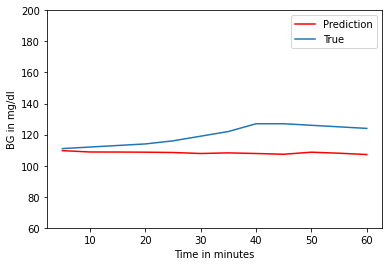

In [305]:
plotBG(27, val_predictions, y_val)


    Predictions  Actuals
0     99.837990    100.0
1     98.691269     99.0
2     99.245758     98.0
3     99.444588     96.0
4     98.206108     94.0
5     98.241661     92.0
6     98.921982     90.0
7     98.787056     88.0
8    101.187836     86.0
9    100.581528     85.0
10    99.622711     84.0
11   101.996643     84.0
Root Mean Squared Error:  10.438523293775201


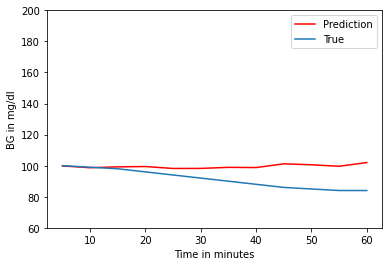

In [306]:
plotBG(2000, val_predictions, y_val)

In [307]:
test_predictions = model.predict(X_test)
test_results = pd.DataFrame(data={'Test Predictions':test_predictions.flatten(), 'True Value':y_test.flatten()})
test_results

,Test Predictions,True Value
0,122.968040,125.0
1,121.415810,122.0
2,118.913544,120.0
3,120.294983,118.0
4,119.361435,121.0
...,...,...
208267,118.666557,147.0
208268,108.688759,153.0
208269,114.175621,156.0
208270,107.930077,154.0


In [308]:
rmse = math.sqrt(mean_squared_error(y_test,test_predictions))
rmse

13.104938979605349

    Predictions  Actuals
0    131.744019    124.0
1    130.457764    119.0
2    128.487106    121.0
3    129.866180    124.0
4    131.376099    127.0
5    127.448425    129.0
6    123.334572    130.0
7    129.038956    126.0
8    128.099091    124.0
9    122.345497    124.0
10   125.561325    127.0
11   128.466522    137.0
Root Mean Squared Error:  6.133037354058697


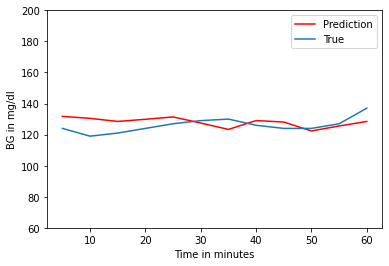

In [309]:
plotBG(6000, test_predictions, y_test)

    Predictions  Actuals
0    130.527618    132.0
1    128.845093    136.0
2    128.044922    144.0
3    125.812561    150.0
4    127.170021    135.0
5    124.333382    132.0
6    125.888847    129.0
7    126.814125    128.0
8    122.828476    128.0
9    122.533981    127.0
10   122.428535    127.0
11   121.394966    125.0
Root Mean Squared Error:  9.594759909690778


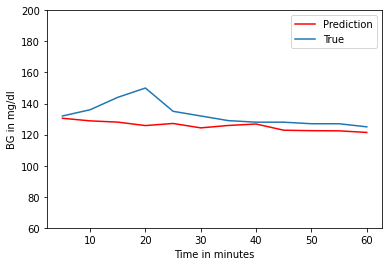

In [310]:
plotBG(8907, test_predictions, y_test)

In [311]:
def clarke_error_grid(ref_values, pred_values, title_string):

    #Checking to see if the lengths of the reference and prediction arrays are the same
    assert (len(ref_values) == len(pred_values)), "Unequal number of values (reference : {}) (prediction : {}).".format(len(ref_values), len(pred_values))

   
    #Clear plot
    plt.clf()

    #Set up plot
    plt.scatter(ref_values, pred_values, marker='.', color='pink', s=8)
    plt.title(title_string + " Clarke Error Grid",fontsize=12 )
    plt.xlabel("True BG (mg/dl)", fontsize=12 )
    plt.ylabel("Prediction BG (mg/dl)",fontsize=12 )
    plt.xticks([0, 50, 100, 150, 200, 250, 300, 350, 400])
    plt.yticks([0, 50, 100, 150, 200, 250, 300, 350, 400])
    plt.gca().set_facecolor('white')

    #Set axes lengths
    plt.gca().set_xlim([0, 400])
    plt.gca().set_ylim([0, 400])
    plt.gca().set_aspect((400)/(400))




    #Plot zone lines
    plt.plot([0,400], [0,400], ':', c='black')                     
    plt.plot([0, 175/3], [70, 70], '-', c='black')
    plt.plot([175/3, 400/1.2], [70, 400], '-', c='black')          
    plt.plot([70, 70], [84, 400],'-', c='black')
    plt.plot([0, 70], [180, 180], '-', c='black')
    plt.plot([70, 290],[180, 400],'-', c='black')
    plt.plot([70, 70], [0, 56], '-', c='black')                    
    plt.plot([70, 400], [56, 320],'-', c='black')
    plt.plot([180, 180], [0, 70], '-', c='black')
    plt.plot([180, 400], [70, 70], '-', c='black')
    plt.plot([240, 240], [70, 180],'-', c='black')
    plt.plot([240, 400], [180, 180], '-', c='black')
    plt.plot([130, 180], [0, 70], '-', c='black')

    #Add zone titles
    plt.text(30, 15, "A", fontsize=15)
    plt.text(370, 260, "B", fontsize=15)
    plt.text(280, 370, "B", fontsize=15)
    plt.text(160, 370, "C", fontsize=15)
    plt.text(160, 15, "C", fontsize=15)
    plt.text(30, 140, "D", fontsize=15)
    plt.text(370, 120, "D", fontsize=15)
    plt.text(30, 370, "E", fontsize=15)
    plt.text(370, 15, "E", fontsize=15)

    #Statistics from the data
    zone = [0] * 5
    for i in range(len(ref_values)):
        if (ref_values[i] <= 70 and pred_values[i] <= 70) or (pred_values[i] <= 1.2*ref_values[i] and pred_values[i] >= 0.8*ref_values[i]):
            zone[0] += 1    #Zone A

        elif (ref_values[i] >= 180 and pred_values[i] <= 70) or (ref_values[i] <= 70 and pred_values[i] >= 180):
            zone[4] += 1    #Zone E

        elif ((ref_values[i] >= 70 and ref_values[i] <= 290) and pred_values[i] >= ref_values[i] + 110) or ((ref_values[i] >= 130 and ref_values[i] <= 180) and (pred_values[i] <= (7/5)*ref_values[i] - 182)):
            zone[2] += 1    #Zone C
        elif (ref_values[i] >= 240 and (pred_values[i] >= 70 and pred_values[i] <= 180)) or (ref_values[i] <= 175/3 and pred_values[i] <= 180 and pred_values[i] >= 70) or ((ref_values[i] >= 175/3 and ref_values[i] <= 70) and pred_values[i] >= (6/5)*ref_values[i]):
            zone[3] += 1    #Zone D
        else:
            zone[1] += 1    #Zone B

    plt.show()
    print('Zone A:',zone[0])
    print('Zone B:',zone[1])
    print('Zone C:',zone[2])
    print('Zone D:',zone[3])
    print('Zone E:',zone[4])
    #Source: https://github.com/suetAndTie/ClarkeErrorGrid/blob/master/ClarkeErrorGrid.py



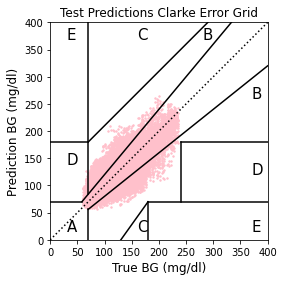

Zone A: 193420
Zone B: 14498
Zone C: 0
Zone D: 354
Zone E: 0


In [312]:
clarke_error_grid(y_test.flatten(), test_predictions.flatten(),'Test Predictions')

## UVA/Padova Simulation

In [313]:
import run

In [332]:
#plotting a few random post meal scenarios 
def UVAsim(i):
  Gb, carbs, bolus = X_test[i][23][0], X_test[i][23][1], X_test[i][23][2]
  #print('Start Glucose',Gb,'\nCarbs',carbs, '\nBolus',bolus)
  pred = run.simulator(Gb,0.3,carbs,bolus)
  return pred[1:-1:5]

UVA Padova is only for post prandial state so that's all we check...

In [339]:
UVApred_arr = []
truepred_arr = []
for i in range(len(X_test)):
  if X_test[i][23][1]!=0: 
    UVApred_arr.append(UVAsim(i))
    truepred_arr.append(y_test[i])



In [341]:
rmse = math.sqrt(mean_squared_error(UVApred_arr,truepred_arr))
rmse

33.466919956641895

In [315]:
def compare(lstm_val, UVA_val, true):
  time_array = [i for i in range(5,65,5)]
  results = pd.DataFrame(data={'Time in min':time_array, 'UVA/Padova Predictions':UVA_val, 'LSTM Predictions':lstm_val.flatten(), 'True Value':true})
  print(results)
  plt.plot(time_array,UVA_val)
  plt.plot(time_array,lstm_val,'r')
  plt.plot(time_array,true)
  plt.ylim(60,200)
  plt.xlabel("Time in minutes")
  plt.ylabel("BG in mg/dl")
  plt.legend(['UVA/Padova','LSTM','True'])
  plt.show()



Start Glucose 111.0 
Carbs 41.0 
Bolus 1.5
    Time in min  UVA/Padova Predictions  LSTM Predictions  True Value
0             5              113.475476        113.193291       108.0
1            10              123.288614        115.025429       104.0
2            15              130.300415        113.720596       105.0
3            20              135.766373        115.930138       112.0
4            25              140.355840        118.571228       119.0
5            30              144.421745        113.082993       123.0
6            35              148.150685        108.240562       127.0
7            40              151.641955        116.606178       133.0
8            45              154.949098        112.613754       137.0
9            50              158.101730        115.972748       136.0
10           55              161.117018        114.766144       133.0
11           60              164.005682        113.629776       131.0


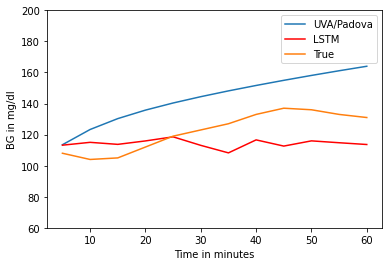

In [316]:
UVApred1 = UVAsim(16917)
lstm_pred1 = model.predict(np.reshape(X_test[16917],(1,24,3)))
compare(lstm_pred1.flatten(), UVApred1, y_test[16917].flatten())

Start Glucose 114.0 
Carbs 115.0 
Bolus 3.5
    Time in min  UVA/Padova Predictions  LSTM Predictions  True Value
0             5              116.451453        117.983551       113.0
1            10              126.149395        115.675522       113.0
2            15              133.074619        113.523582       112.0
3            20              138.509155        111.188782       110.0
4            25              143.125246        108.069382       108.0
5            30              147.264347         99.038414       104.0
6            35              151.098917         96.078400       100.0
7            40              154.715634         91.096397        99.0
8            45              158.157971         87.485512       101.0
9            50              161.447946         92.977623        99.0
10           55              164.597169         84.493538        96.0
11           60              167.612411         83.892746        89.0


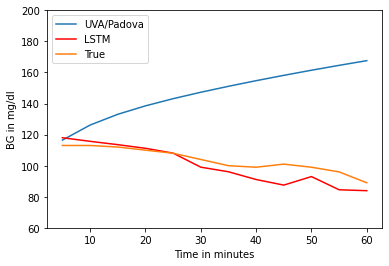

In [317]:
UVApred2 = UVAsim(9874)
lstm_pred2 = model.predict(np.reshape(X_test[9874],(1,24,3)))
compare(lstm_pred2.flatten(), UVApred2, y_test[9874].flatten())

Start Glucose 79.0 
Carbs 8.0 
Bolus 0.0
    Time in min  UVA/Padova Predictions  LSTM Predictions  True Value
0             5               81.732520         84.192963        77.0
1            10               92.832323         88.041946        80.0
2            15              101.098123         97.852783        90.0
3            20              107.745482         95.633492        98.0
4            25              113.429538         96.989571       101.0
5            30              118.505841        100.833267        98.0
6            35              123.169622        107.295929        94.0
7            40              127.530104        111.727066        96.0
8            45              131.650174        116.931030        98.0
9            50              135.567601        119.271690       101.0
10           55              139.306412        118.830200       106.0
11           60              142.883001        120.431213       108.0


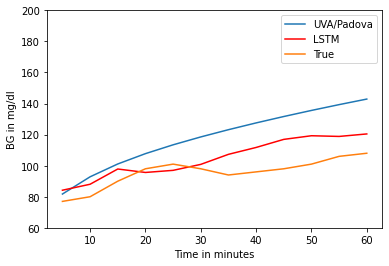

In [318]:
UVApred3 = UVAsim(404)
lstm_pred3 = model.predict(np.reshape(X_test[404],(1,24,3)))
compare(lstm_pred3.flatten(), UVApred3, y_test[404].flatten())